# News Recommendation System


In [1]:
import numpy as np
import pandas as pd
import os
import math
import time
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances

## Loading Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
raw_df = pd.read_json(r"/content/drive/MyDrive/NLP/News_Category_Dataset_v2.json", lines = True)

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [5]:
raw_df.describe()

,date
count,200853
mean,2015-02-06 05:55:12.542008576
min,2012-01-28 00:00:00
25%,2013-07-18 00:00:00
50%,2015-01-25 00:00:00
75%,2016-08-19 00:00:00
max,2018-05-26 00:00:00


In [6]:
raw_df.columns.unique()

Index(['category', 'headline', 'authors', 'link', 'short_description', 'date'], dtype='object')

In [7]:
raw_df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [8]:
raw_df.tail()

,category,headline,authors,link,short_description,date
200848,TECH,RIM CEO Thorsten Heins' 'Significant' Plans Fo...,"Reuters, Reuters",https://www.huffingtonpost.com/entry/rim-ceo-t...,Verizon Wireless and AT&T are already promotin...,2012-01-28
200849,SPORTS,Maria Sharapova Stunned By Victoria Azarenka I...,,https://www.huffingtonpost.com/entry/maria-sha...,"Afterward, Azarenka, more effusive with the pr...",2012-01-28
200850,SPORTS,"Giants Over Patriots, Jets Over Colts Among M...",,https://www.huffingtonpost.com/entry/super-bow...,"Leading up to Super Bowl XLVI, the most talked...",2012-01-28
200851,SPORTS,Aldon Smith Arrested: 49ers Linebacker Busted ...,,https://www.huffingtonpost.com/entry/aldon-smi...,CORRECTION: An earlier version of this story i...,2012-01-28
200852,SPORTS,Dwight Howard Rips Teammates After Magic Loss ...,,https://www.huffingtonpost.com/entry/dwight-ho...,The five-time all-star center tore into his te...,2012-01-28


## Data Preprocessing

#### Fetching only the articles from 2018

Since the dataset size is quite large so processing through entire dataset may consume too much time.

In [9]:
start_date = pd.Timestamp(2016, 1, 1)
raw_df = raw_df[raw_df['date'] >= start_date]

In [10]:
raw_df.shape

(70570, 6)

In [11]:
raw_df.sort_values('headline', inplace=True, ascending=False)

duplicate_raw_df = raw_df.duplicated('headline', keep=False)

raw_df = raw_df[~duplicate_raw_df]

print(raw_df.shape)

(70317, 6)


#### Checking for null values

In [12]:
raw_df.isna().sum()

,0
category,0
headline,0
authors,0
link,0
short_description,0
date,0


In [13]:
raw_df.reset_index(inplace = True)
raw_df

,index,category,headline,authors,link,short_description,date
0,36290,WOMEN,"“We Shall Overcomb!” Say The 100,000 Marching ...","Darin Graham, ContributorJournalist",https://www.huffingtonpost.com/entry/we-shall-...,Thousands of activists descended on London to ...,2017-01-25
1,21194,HEALTHY LIVING,“To The Bone” Didn’t Teach Me Glamour. It Taug...,"Mycah Hazel, Contributorblogger, equal opportu...",https://www.huffingtonpost.com/entry/to-the-bo...,"Oftentimes, films or TV shows about eating dis...",2017-07-18
2,29672,BUSINESS,"“I’m Sorry""--The Two Tragically Forgotten Word...","Dana Brownlee, ContributorPresident of Profess...",https://www.huffingtonpost.com/entry/im-sorryt...,"Unfortunately, I was one of those frustrated p...",2017-04-10
3,2932,QUEER VOICES,‘Will & Grace’ Creator To Donate Gay Bunny Boo...,Elyse Wanshel,https://www.huffingtonpost.com/entry/will-grac...,It's about to be a lot easier for kids in Mike...,2018-04-02
4,67601,WEIRD NEWS,‘Wild Boar Curling’ Rescues Stranded Wild Boar...,Nina Golgowski,https://www.huffingtonpost.com/entry/wild-boar...,Get this pig in a blanket!,2016-02-03
...,...,...,...,...,...,...,...
70312,60589,ENTERTAINMENT,"""Bosch"" Is Back and Better Than Ever","Jackie K. Cooper, ContributorFilm Critic",https://www.huffingtonpost.com/entry/bosch-is-...,,2016-04-24
70313,68627,POLITICS,"""Black Lives Matter"" (the ""Too"" Is Silent)","Rick Horowitz, ContributorMilwaukee Public TV ...",https://www.huffingtonpost.com/entry/black-liv...,It's pretty easy to understand. Unless you're ...,2016-01-23
70314,50799,ENTERTAINMENT,"""Bachelors"" Is a Profanity Laden RomCom","Jackie K. Cooper, ContributorFilm Critic",https://www.huffingtonpost.com/entry/bachelors...,,2016-08-13
70315,40225,ENTERTAINMENT,"""An International Film Festival with an Arab H...","E. Nina Rothe, ContributorCultural Activist",https://www.huffingtonpost.com/entry/an-intern...,,2016-12-11


#### Removing all the short headline articles

In [39]:
counts = raw_df.category.value_counts()
print(counts)

category
POLITICS          22647
ENTERTAINMENT      8349
THE WORLDPOST      3092
QUEER VOICES       2960
HEALTHY LIVING     2548
COMEDY             2524
BLACK VOICES       2443
WORLD NEWS         2106
SPORTS             2072
PARENTS            1900
WOMEN              1762
WEIRD NEWS         1546
MEDIA              1434
CRIME              1414
BUSINESS           1354
ARTS & CULTURE     1113
STYLE              1029
GREEN              1018
TASTE               914
IMPACT              781
TECH                735
TRAVEL              725
LATINO VOICES       722
RELIGION            676
GOOD NEWS           619
SCIENCE             503
EDUCATION           311
COLLEGE             224
WORLDPOST           206
FIFTY               149
ARTS                 76
Name: count, dtype: int64


In [15]:
raw_df = raw_df[raw_df['headline'].str.split().apply(len) > 5]
total_articles = len(raw_df)
print("Total number of articles after removing headlines with fewer than 5 words:", total_articles)

Total number of articles after removing headlines with fewer than 5 words: 67952


In [16]:
raw_df['category']

,category
0,WOMEN
1,HEALTHY LIVING
2,BUSINESS
3,QUEER VOICES
4,WEIRD NEWS
...,...
70312,ENTERTAINMENT
70313,POLITICS
70314,ENTERTAINMENT
70315,ENTERTAINMENT


## Data Visualization

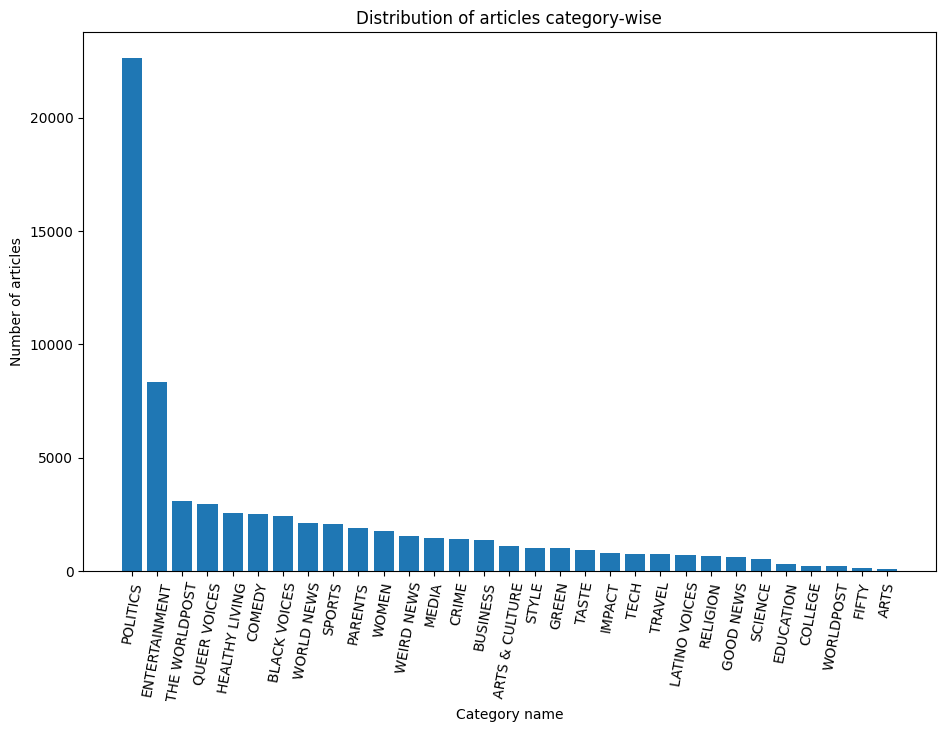

In [17]:
category_counts = raw_df["category"].value_counts()

plt.figure(figsize=(11, 7))
plt.bar(category_counts.index, category_counts.values)
plt.title("Distribution of articles category-wise")
plt.xlabel("Category name")
plt.ylabel("Number of articles")
plt.xticks(rotation=80)
plt.show()

In [18]:
news_articles_per_month = raw_df['date'].dt.month.value_counts().sort_index()
news_articles_per_month

,count
date,
1,7443
2,6666
3,6965
4,6520
5,6526
6,5059
7,4936
8,5096
9,4678


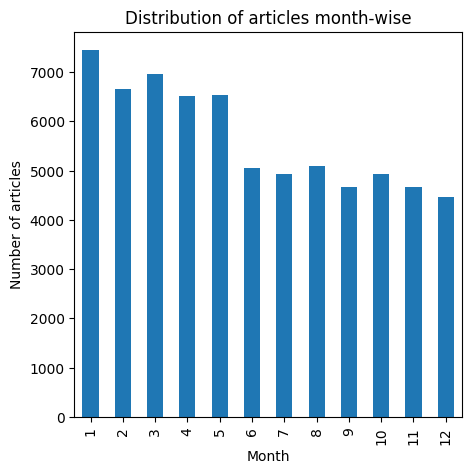

In [19]:
news_articles_per_month.plot(kind='bar', figsize=(5, 5))
plt.title("Distribution of articles month-wise")
plt.xlabel("Month")
plt.ylabel("Number of articles")
plt.show()

In [20]:
raw_df_temp = raw_df.copy()

In [21]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
# Set of stopwords in English
stop_words = set(stopwords.words('english'))

# Loop through each headline in the DataFrame
for i, headline in enumerate(raw_df_temp["headline"]):
    processed_words = []

    # Split the headline into individual words
    for word in headline.split():
        # Remove punctuation and convert to lowercase
        word = ''.join(e for e in word if e.isalnum())
        word = word.lower()

        # Check if word is not a stopword
        if word not in stop_words:
            processed_words.append(word)

    # Join the processed words and assign back to the DataFrame
    raw_df_temp.at[i, "headline"] = ' '.join(processed_words)

    # Print progress every 1000 iterations
    if i % 1000 == 0:
        print(i)


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000


#### Lemmatization

In [23]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [24]:
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

for i in range(len(raw_df_temp["headline"])):
    if i in raw_df_temp.index:
        string = ""
        for w in word_tokenize(raw_df_temp["headline"][i]):
            string += lemmatizer.lemmatize(w, pos="v") + " "
        raw_df_temp.at[i, "headline"] = string.strip()
    if i % 1000 == 0:
        print(i)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000


## TF-IDF method

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Combine text features
raw_df['combined_text'] = raw_df['headline'] + " " + raw_df['short_description']

# Text cleaning function
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text
raw_df['cleaned_text'] = raw_df['combined_text'].apply(clean_text)

<ipython-input-25-d6e93796a6d2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['combined_text'] = raw_df['headline'] + " " + raw_df['short_description']
<ipython-input-25-d6e93796a6d2>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['cleaned_text'] = raw_df['combined_text'].apply(clean_text)


In [26]:
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(raw_df['cleaned_text'])

In [27]:
# First create count vectors
count_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
count_matrix = count_vectorizer.fit_transform(raw_df['cleaned_text'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=10, random_state=42)
lda_topics = lda.fit_transform(count_matrix)

**Sentence Transformer (BERT-based)**

In [28]:
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings (this may take time for large datasets)
bert_embeddings = model.encode(raw_df['combined_text'].tolist(), show_progress_bar=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Batches:   0%|          | 0/2124 [00:00<?, ?it/s]

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

class NewsRecommender:
    def __init__(self, df, feature_matrix, feature_type='tfidf'):
        self.df = df.reset_index(drop=True)
        # Convert feature matrix to array if it's a sparse matrix or numpy matrix
        if hasattr(feature_matrix, 'toarray'):
            self.feature_matrix = feature_matrix.toarray()
        elif isinstance(feature_matrix, np.matrix):
            self.feature_matrix = np.asarray(feature_matrix)
        else:
            self.feature_matrix = feature_matrix
        self.feature_type = feature_type

    def recommend(self, user_history_indices, num_recommendations=5):
        """
        user_history_indices: List of article indices the user has interacted with
        num_recommendations: Number of articles to recommend
        """
        # Ensure user_history_indices is not empty
        if not user_history_indices:
            return self.df.sample(num_recommendations)

        # Convert to array and ensure proper shape
        user_history_indices = np.array(user_history_indices).flatten()

        # Get user profile (average of interacted articles)
        user_profile = np.mean(self.feature_matrix[user_history_indices], axis=0)

        # Reshape if necessary (for single sample)
        if len(user_profile.shape) == 1:
            user_profile = user_profile.reshape(1, -1)
        similarities = cosine_similarity(user_profile, self.feature_matrix).flatten()

        # Get top similar articles (excluding already seen)
        similar_indices = np.argsort(similarities)[::-1]
        recommendations = [
            idx for idx in similar_indices
            if idx not in user_history_indices
        ][:num_recommendations]

        return self.df.iloc[recommendations]

In [30]:
# Initialize with your preferred method
# For TF-IDF:
recommender = NewsRecommender(raw_df, tfidf_matrix, 'tfidf')
user_history = [10, 42, 100]
recommendations = recommender.recommend(user_history, num_recommendations=5)
print(recommendations[['headline', 'category', 'date']])

                                                headline        category  \
6618   Twitter Users Skewer Donald Trump For Skipping...          COMEDY   
31583  Michael Moore Is Taking His Criticism Of Trump...  ARTS & CULTURE   
8745   Trump Is Prepping Executive Orders For EPA: Re...        POLITICS   
10310       To Those Who Think They Can Derail My Dreams           WOMEN   
48602            Executive Orders Signed By Donald Trump        POLITICS   

            date  
6618  2017-04-01  
31583 2017-05-01  
8745  2017-02-15  
10310 2017-06-03  
48602 2017-03-07  


In [31]:
# For BERT:
recommender = NewsRecommender(raw_df, bert_embeddings, 'bert')
recommendations = recommender.recommend(user_history, num_recommendations=5)
print(recommendations[['headline', 'category', 'date']])

                                                headline        category  \
66225  'Trump: An American Musical' Is Like A Train W...          COMEDY   
21546  SATIRE:  Trump, The Pop Musical;  Or, A Few Su...        POLITICS   
18135  Stephen Colbert’s Donald Trump-Inspired Artwor...          COMEDY   
63276  A Sketch By Donald Trump Is Headed To Auction,...  ARTS & CULTURE   
51116  Donald Trump May Actually Enjoy Jim Carrey's L...   ENTERTAINMENT   

            date  
66225 2016-12-29  
21546 2016-07-16  
18135 2018-03-15  
63276 2017-07-25  
51116 2018-04-24  


In [32]:
# For LDA:
recommender = NewsRecommender(raw_df, lda_topics, 'lda')
recommendations = recommender.recommend(user_history, num_recommendations=5)
print(recommendations[['headline', 'category', 'date']])

                                                headline       category  \
18993  Someone Made Donald Trump's Speeches Into An E...         COMEDY   
16632  Ted Nugent Grabbing His Crotch During Trump Ra...       POLITICS   
54662  Comedy Central Imagines The Sound Engineer For...  ENTERTAINMENT   
17948  Stop Comparing 'Emailgate' To Watergate, Says ...       POLITICS   
37070  Joe Arpaio Has A 'Free Pair Of Pink Underwear'...       POLITICS   

            date  
18993 2017-03-27  
16632 2016-11-07  
54662 2018-04-14  
17948 2016-10-31  
37070 2016-02-23  


In [33]:
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# Assuming raw_df is already defined and cleaned
# Combine text features (headline + short_description)
raw_df['combined_text'] = raw_df['headline'] + " " + raw_df['short_description']

# Text cleaning function (as defined earlier)
def clean_text(text):
    import re
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

# Apply the cleaning function
raw_df['cleaned_text'] = raw_df['combined_text'].apply(clean_text)

# Define and fit the TF-IDF vectorizer
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(raw_df['cleaned_text'])

# Save the trained Keras model (assuming it's already defined and trained)
model.save("Nlp_model.keras")

# Save the trained TF-IDF vectorizer to a .pkl file
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ Model (.keras) and vectorizer (.pkl) saved successfully.")


<ipython-input-33-d089c167955e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['combined_text'] = raw_df['headline'] + " " + raw_df['short_description']
<ipython-input-33-d089c167955e>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  raw_df['cleaned_text'] = raw_df['combined_text'].apply(clean_text)


✅ Model (.keras) and vectorizer (.pkl) saved successfully.


In [34]:
# After training your model
model.save("models/Nlp_model.keras")


In [37]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

# Save it as a folder
model.save("sentence_model")  # This creates a directory
